In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import copy

In [2]:
batch_size = 64
num_epochs = 30
early_stop_patience = 3
data_dir = '../data/MNIST'

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307, 0.1307, 0.1307],
                         std=[0.3081, 0.3081, 0.3081])
])

train_dataset = MNIST(root= data_dir, train=True, download=True, transform=transform)
test_dataset = MNIST(root= data_dir, train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.alexnet(pretrained=False)
model.classifier[6] = nn.Linear(4096, 10)
model.to(device)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# for param in model.parameters():
#     param.requires_grad = True

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, test_losses, train_accs, test_accs = [], [], [], []
best_loss = float('inf')
patience = 0
best_epoch = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    total, correct, train_loss = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(acc)

    model.eval()
    total, correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    test_losses.append(val_loss / len(test_loader))
    test_accs.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Train Acc: {acc:.4f} | Test Acc: {val_acc:.4f}")

    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        best_model = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        patience = 0
    else:
        patience += 1
        if patience >= early_stop_patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch+1}. Best model was from epoch {best_epoch}.")
            break


Epoch 01 | Train Loss: 0.1610 | Test Loss: 0.0424 | Train Acc: 0.9482 | Test Acc: 0.9854
Epoch 02 | Train Loss: 0.0471 | Test Loss: 0.0207 | Train Acc: 0.9851 | Test Acc: 0.9935
Epoch 03 | Train Loss: 0.0334 | Test Loss: 0.0256 | Train Acc: 0.9896 | Test Acc: 0.9919
Epoch 04 | Train Loss: 0.0283 | Test Loss: 0.0265 | Train Acc: 0.9913 | Test Acc: 0.9924
Epoch 05 | Train Loss: 0.0239 | Test Loss: 0.0181 | Train Acc: 0.9927 | Test Acc: 0.9946
Epoch 06 | Train Loss: 0.0206 | Test Loss: 0.0252 | Train Acc: 0.9935 | Test Acc: 0.9923
Epoch 07 | Train Loss: 0.0185 | Test Loss: 0.0234 | Train Acc: 0.9942 | Test Acc: 0.9936
Epoch 08 | Train Loss: 0.0158 | Test Loss: 0.0201 | Train Acc: 0.9951 | Test Acc: 0.9940

🛑 Early stopping triggered at epoch 8. Best model was from epoch 5.


In [6]:
if best_model is not None:
    model.load_state_dict(best_model)

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        correct += (model(x).argmax(1) == y).sum().item()
        total += y.size(0)

print(f"\n✅ Final MNIST Test Accuracy: {correct / total:.4f}")


✅ Final MNIST Test Accuracy: 0.9946


In [7]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes if hasattr(test_dataset, 'classes') else [str(i) for i in range(10)]))



📊 Classification Report:
              precision    recall  f1-score   support

    0 - zero       1.00      0.99      0.99       980
     1 - one       0.99      1.00      1.00      1135
     2 - two       1.00      0.99      1.00      1032
   3 - three       1.00      1.00      1.00      1010
    4 - four       0.99      1.00      0.99       982
    5 - five       0.99      1.00      0.99       892
     6 - six       0.99      1.00      0.99       958
   7 - seven       1.00      0.99      1.00      1028
   8 - eight       1.00      0.99      1.00       974
    9 - nine       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



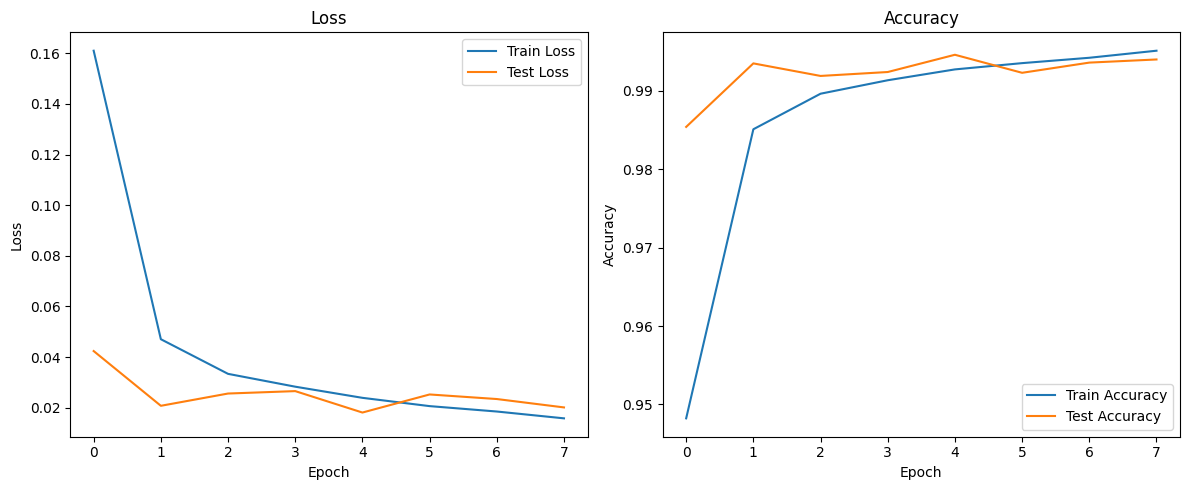

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
print(train_losses)
print(test_losses)
print(train_accs)
print(test_accs)

[0.16103261336051264, 0.04705213839062867, 0.03336831320473775, 0.028297756852599845, 0.02389507276173871, 0.02062052251594088, 0.018487594784162356, 0.01579196331354389]
[0.042374464917780054, 0.020747465643244662, 0.025594070170285657, 0.026547887946122548, 0.018083145893733613, 0.02522616346764761, 0.02342012098777278, 0.02010659274723711]
[0.9482333333333334, 0.9851, 0.9896333333333334, 0.99135, 0.9927333333333334, 0.9935333333333334, 0.9942166666666666, 0.9951166666666666]
[0.9854, 0.9935, 0.9919, 0.9924, 0.9946, 0.9923, 0.9936, 0.994]
